In [14]:
import rioxarray as riox
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import fiona
import geopandas as gpd
from shapely.geometry import Point
import rasterio.plot

In [3]:
# Open file with rioxarray
path = r'D:\Enline\EVGM_GEB\Files\dem\output_COP30.tif'
raster_xarr = riox.open_rasterio(path)

In [4]:
# reproject to standard CRS
epsg_code = 4326
raster_xarr = raster_xarr.rio.reproject("EPSG:"+str(epsg_code))

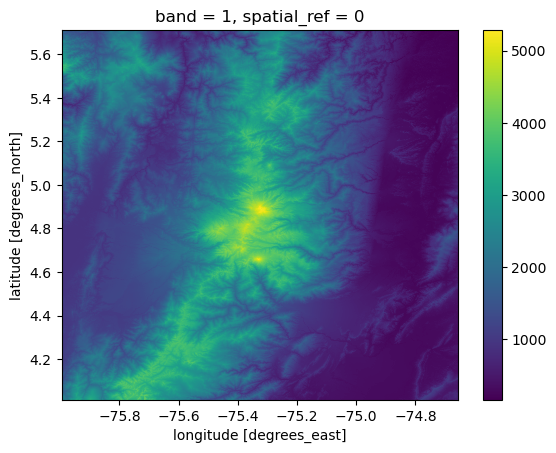

In [5]:
# Visualize altitudes
raster_xarr.plot()

In [6]:
# Find xy coords on the array of all the maximum points
max_points = np.argwhere(raster_xarr[0].data == raster_xarr[0].data.max())
max_points

array([[2940, 2417]], dtype=int64)

In [7]:
# Array to save geographical coordinates of the max points 
max_points_coords = []

# Index of the band to use
band = 0

# Loop to convert each point in max_points to lat/long
for point in max_points:
    # For some reason Y value comes before X value, so X = [1] and Y = [0]
    # new array will have [X,Y] format
    x_index = point[1]
    y_index = point[0]
    point_coords = [raster_xarr.coords['x'].data[x_index], 
                    raster_xarr.coords['y'].data[y_index]]
    max_points_coords.append(point_coords)

In [8]:
max_points_coords

[[-75.32375000000002, 4.893888888888888]]

In [9]:
# Array to save shapely points
max_points_arr = []

# Makes a shapely point for each coordinate pair in max_point_coords
for point in max_points_coords:
    max_points_arr.append(Point(point[0], point[1]))

# Saves shapely points to a geodataframe using the same CRS
max_points_df = gpd.GeoDataFrame({'geometry':max_points_arr}, 
                                geometry='geometry', crs=epsg_code)

<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

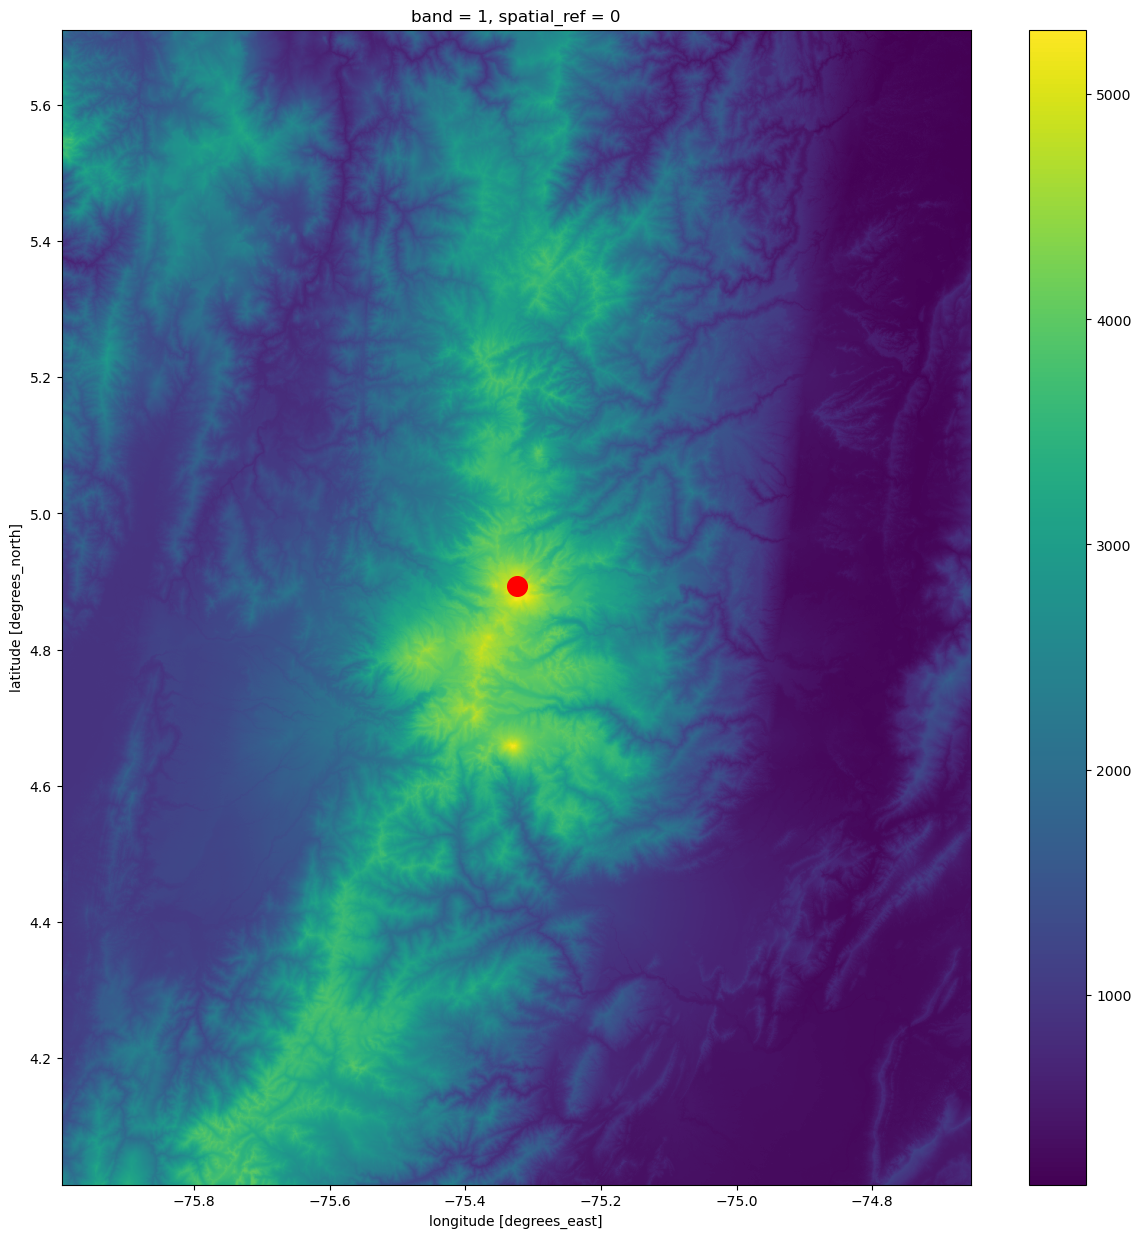

In [10]:
# Plots the points from Geodataframe on top of the raster image
fig, ax = plt.subplots(figsize=(15, 15))
raster_xarr.plot(ax=ax)
max_points_df.plot(ax=ax,color='red', markersize = 200)

In [11]:
max_points_df

,geometry
0,POINT (-75.32375 4.89389)


In [12]:
# Check CRS of the dataframe
max_points_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# Saves the geodataframe in a shapefile using a workarround due to bug in geopandas
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    max_points_df.to_file('max_points_df.shp')


In [16]:
# Read created file using a workarround due to bug in geopandas
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
   gdf = gpd.read_file("max_points_df.shp")

In [17]:
gdf

,FID,geometry
0,0,POINT (-75.32375 4.89389)
